# Imports

In [184]:
# All imports

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.metrics import categorical_accuracy

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import glob
from sklearn.utils import class_weight
import numpy as np

import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'1.14.0'

# Data Loading

In [47]:
# unzipping files

import zipfile
with zipfile.ZipFile('./trafficsigns_shapedata.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [179]:
# Loading image path and labels
image_list = []
for filepath in glob.glob('./trafficsigns_shapedata/*/*.png', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    label = filepath.split("/")[-2]
    image_list.append((filepath, label))
    
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'label'])

# Inspecting Data

In [180]:
data.head()

,image_path,label
0,./trafficsigns_shapedata/square/00290_00001.png,square
1,./trafficsigns_shapedata/square/01577_00000.png,square
2,./trafficsigns_shapedata/square/01366_00000.png,square
3,./trafficsigns_shapedata/square/00482_00000.png,square
4,./trafficsigns_shapedata/square/01731_00000.png,square


In [181]:
print(data.shape)
data.label.unique()

(3650, 2)


array(['square', 'diamond', 'hex', 'triangle', 'round'], dtype=object)

Data contains two columns, having location of image and its corresponding label. We have a total of 5 label classes from which we need to classify. our total dataset contains 3650 images

In [182]:
data.groupby(['label']).count()

,image_path
label,
diamond,282
hex,43
round,1711
square,688
triangle,926


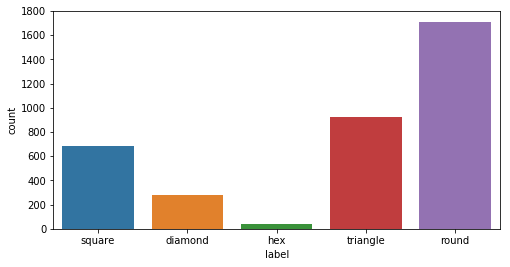

In [183]:
plt.figure(figsize=(8,4))
sns.countplot(x='label', data=data);# unbalanced classes

In [173]:
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)

We can see from above visualisation that classes are unbalanced

# Display images

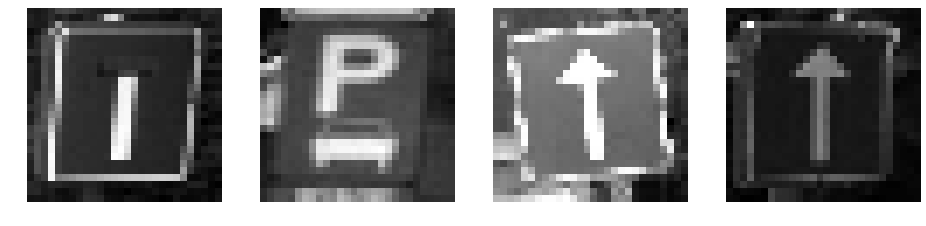

In [67]:
# displaying random images

r_inx = np.random.choice(100, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

# Label mapping

In [68]:
#label mapping
d = {'square':0, 'diamond':1, 'hex':2, 'triangle':3, 'round':4}
data['labels_num'] = data['label'].map(d, na_action='ignore')

# Train Test split

In [69]:
#generating training, testing and validation sets

temptrainData, testData = train_test_split(data ,test_size=0.20, random_state=42)
trainData, validateData = train_test_split(temptrainData ,test_size=0.25, random_state=42)

In [70]:
print(trainData.shape)
print(testData.shape)
print(validateData.shape)

(2190, 3)
(730, 3)
(730, 3)


In [71]:
N_train_images = trainData.shape[0]
N_val_images = validateData.shape[0]
N_test_images = testData.shape[0]

# Some other utility functions

In [72]:
def calculate_losses(model_in, data_generator_in, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    
    # iterate over each batch
    for x,y in data_generator_in:
        loss, acc = model_in.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
    return np.mean(loss_hold), np.mean(acc_hold)

In [100]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res.history['loss'])
    plt.plot(res.history['val_loss'])
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(res.history['categorical_accuracy'])
    plt.plot(res.history['val_categorical_accuracy'])
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')

In [74]:
def train_model(model_, num_epoch=50, verbose=False):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

# Image Data Generators 

- to augment the image and load into batches to increase computational efficiency

In [185]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validateData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

batch_size_t = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=testData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical',
shuffle = False)


Found 2190 validated image filenames belonging to 5 classes.
Found 730 validated image filenames belonging to 5 classes.
Found 730 validated image filenames belonging to 5 classes.


# Creating model (CNN)

- starting with the most basic model (model 1)

In [155]:
model_cnn = Sequential()

model_cnn.add(Conv2D(32, (3, 3), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())
model_cnn.add(Dense(5))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
activation_68 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 5)                 27045     
_________________________________________________________________
activation_69 (Activation)   (None, 5)                 0         
Total params: 27,941
Trainable params: 27,941
Non-trainable params: 0
_________________________________________________

In [164]:
res = model_cnn.fit(x=train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=30)

Epoch 1/30
137/137 [==============================] - 4s 31ms/step - loss: 1.2893 - categorical_accuracy: 0.4735 - val_loss: 1.2220 - val_categorical_accuracy: 0.4767
Epoch 2/30
137/137 [==============================] - 3s 21ms/step - loss: 1.0938 - categorical_accuracy: 0.5589 - val_loss: 0.8541 - val_categorical_accuracy: 0.6562
Epoch 3/30
137/137 [==============================] - 3s 22ms/step - loss: 0.8406 - categorical_accuracy: 0.6799 - val_loss: 0.6857 - val_categorical_accuracy: 0.7630
Epoch 4/30
137/137 [==============================] - 3s 22ms/step - loss: 0.7283 - categorical_accuracy: 0.7210 - val_loss: 0.5221 - val_categorical_accuracy: 0.8342
Epoch 5/30
137/137 [==============================] - 3s 21ms/step - loss: 0.5809 - categorical_accuracy: 0.7868 - val_loss: 0.2836 - val_categorical_accuracy: 0.9164
Epoch 6/30
137/137 [==============================] - 3s 22ms/step - loss: 0.4886 - categorical_accuracy: 0.8288 - val_loss: 0.2060 - val_categorical_accuracy: 0.941

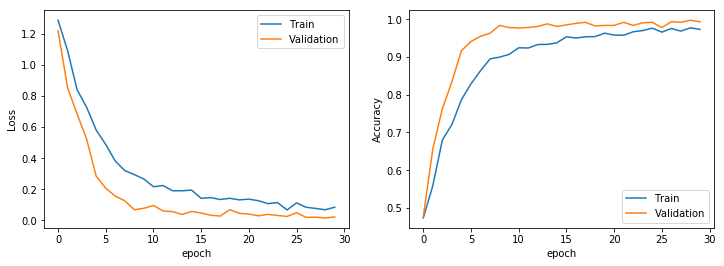

In [165]:
plot_results(res)

In [177]:
model_cnn.evaluate(test_generator)

58/58 [==============================] - 0s 2ms/step - loss: 0.5081 - categorical_accuracy: 0.8793


[0.5081046070775082, 0.87931037]

# Increasing the complexity of model by adding more layers

- model number 2

In [159]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(28, 28, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [ ]:
res = model_cnn.fit(x=train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=30)

In [ ]:
plot_results(res)

In [ ]:
model_cnn.evaluate(test_generator)

 - model number 3

In [163]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (3, 3)))
model_cnn.add(Activation('relu'))
#model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dense(5))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
activation_70 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_71 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
activation_72 (Activation)   (None, 9, 9, 64)        

In [133]:
res = model_cnn.fit(x=train_generator, batch_size=batch_size, validation_data=validation_generator, epochs=30)

Epoch 1/30
137/137 [==============================] - 4s 30ms/step - loss: 1.2836 - categorical_accuracy: 0.4749 - val_loss: 1.2368 - val_categorical_accuracy: 0.4658
Epoch 2/30
137/137 [==============================] - 3s 23ms/step - loss: 1.1947 - categorical_accuracy: 0.5132 - val_loss: 0.9342 - val_categorical_accuracy: 0.6205
Epoch 3/30
137/137 [==============================] - 3s 22ms/step - loss: 0.9247 - categorical_accuracy: 0.6416 - val_loss: 0.6314 - val_categorical_accuracy: 0.7781
Epoch 4/30
137/137 [==============================] - 3s 21ms/step - loss: 0.7106 - categorical_accuracy: 0.7365 - val_loss: 0.3281 - val_categorical_accuracy: 0.9000
Epoch 5/30
137/137 [==============================] - 3s 22ms/step - loss: 0.5286 - categorical_accuracy: 0.8169 - val_loss: 0.2499 - val_categorical_accuracy: 0.9178
Epoch 6/30
137/137 [==============================] - 3s 21ms/step - loss: 0.4347 - categorical_accuracy: 0.8498 - val_loss: 0.1567 - val_categorical_accuracy: 0.938

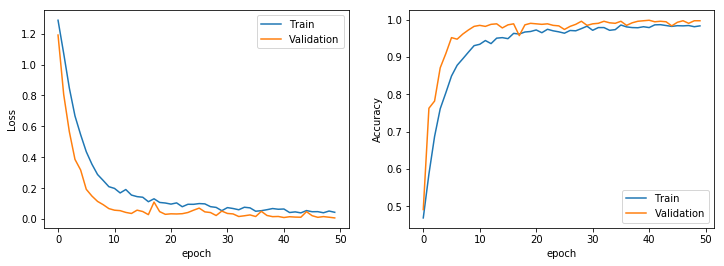

In [114]:
plot_results(res)

In [ ]:
model_cnn.evaluate(test_generator)

- model number 4

Incorporating regularisation and dropout 

In [174]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001), input_shape=(28, 28, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation('relu'))
#model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(5))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_cnn.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
activation_80 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_81 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
activation_82 (Activation)   (None, 9, 9, 64)        

In [176]:
res = model_cnn.fit(x=train_generator, batch_size=batch_size, validation_data=validation_generator,class_weight=class_weights, epochs=30)

Epoch 1/30
137/137 [==============================] - 5s 34ms/step - loss: 1.3533 - categorical_accuracy: 0.4676 - val_loss: 1.3038 - val_categorical_accuracy: 0.4658
Epoch 2/30
137/137 [==============================] - 3s 21ms/step - loss: 1.2814 - categorical_accuracy: 0.4886 - val_loss: 1.1257 - val_categorical_accuracy: 0.5959
Epoch 3/30
137/137 [==============================] - 3s 21ms/step - loss: 1.1773 - categorical_accuracy: 0.5470 - val_loss: 0.8856 - val_categorical_accuracy: 0.6808
Epoch 4/30
137/137 [==============================] - 3s 22ms/step - loss: 1.0411 - categorical_accuracy: 0.6091 - val_loss: 0.6042 - val_categorical_accuracy: 0.8192
Epoch 5/30
137/137 [==============================] - 3s 22ms/step - loss: 0.8432 - categorical_accuracy: 0.6936 - val_loss: 0.4779 - val_categorical_accuracy: 0.8630
Epoch 6/30
137/137 [==============================] - 3s 22ms/step - loss: 0.7007 - categorical_accuracy: 0.7667 - val_loss: 0.3594 - val_categorical_accuracy: 0.923

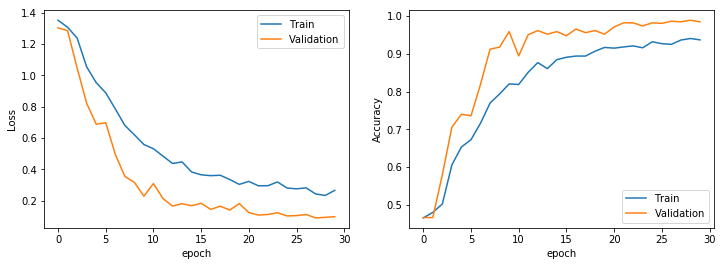

In [169]:
plot_results(res)

In [ ]:
model_cnn.evaluate(test_generator)

# Prediction below

- Training Test prediction

In [136]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
test_generator = test_datagen.flow_from_dataframe(
        dataframe=testData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical',
shuffle = False)


Found 58 validated image filenames belonging to 5 classes.


[[2.9438814e-07 1.5370264e-05 1.9869194e-03 9.9799418e-01 3.2163300e-06]]
[[0. 0. 0. 1. 0.]]
[[0.07870171 0.05199582 0.34371677 0.27875462 0.24683097]]
[[1. 0. 0. 0. 0.]]
[[9.1382396e-01 2.1685168e-02 5.7349972e-02 5.0965526e-05 7.0899432e-03]]
[[1. 0. 0. 0. 0.]]
[[0.2172995  0.02004565 0.751116   0.00166146 0.00987753]]
[[1. 0. 0. 0. 0.]]
[[0.02008896 0.02695664 0.88157654 0.03448525 0.03689257]]
[[1. 0. 0. 0. 0.]]


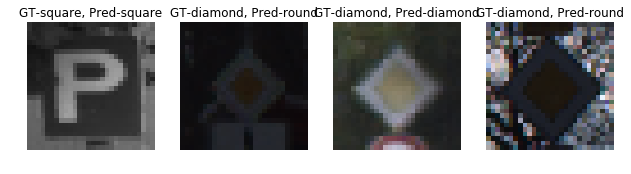

In [137]:
labels = (test_generator.class_indices)

d_inv = {v: k for k, v in labels.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_cnn.predict(x, verbose=0)
        print(y_hat)
        print(y)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,6,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

# Independent evaluation

In [2]:
#TEST DATA LOADING

In [3]:
# unzipping files

import zipfile
with zipfile.ZipFile('./test_shapedata.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [120]:
# Loading image path and labels
image_list = []
for filepath in glob.glob('./test_shapedata/*/*.ppm', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    label = filepath.split("/")[-2]
    image_list.append((filepath, label))
    
# Create a data frame
TestData = pd.DataFrame(data=image_list, columns=['image_path', 'label'])

In [121]:
TestData.tail()

,image_path,label
53,./test_shapedata/round/00001.ppm,round
54,./test_shapedata/round/00013.ppm,round
55,./test_shapedata/round/00011.ppm,round
56,./test_shapedata/round/00000.ppm,round
57,./test_shapedata/round/00005.ppm,round


In [122]:
TestData.shape

(58, 2)

In [151]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
test_generator = test_datagen.flow_from_dataframe(
        dataframe=TestData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical',
shuffle = False)



Found 58 validated image filenames belonging to 5 classes.


[[2.2449074e-11 7.1544726e-10 6.2311024e-08 1.1258862e-07 9.9999988e-01]]
[[0. 0. 0. 0. 1.]]
[[2.8918689e-04 2.2558344e-03 6.1058626e-03 1.4317051e-03 9.8991746e-01]]
[[0. 0. 0. 0. 1.]]
[[2.8025401e-10 3.6261081e-09 1.5320670e-06 9.9999845e-01 1.1013060e-08]]
[[0. 0. 0. 1. 0.]]
[[2.7272546e-07 1.5879418e-04 9.9982578e-01 1.9117999e-07 1.4899169e-05]]
[[0. 0. 1. 0. 0.]]
[[6.3018826e-12 7.1611289e-08 9.9999988e-01 3.1003120e-10 4.6183455e-08]]
[[0. 0. 1. 0. 0.]]


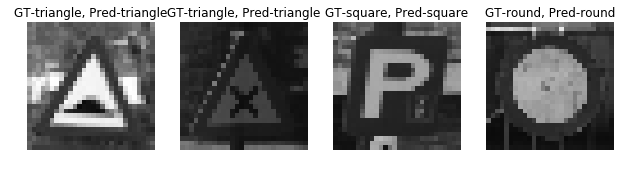

In [139]:
labels = (test_generator.class_indices)

d_inv = {v: k for k, v in labels.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_cnn.predict(x, verbose=0)
        print(y_hat)
        print(y)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,6,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [152]:
model_cnn.evaluate(test_generator)

58/58 [==============================] - 0s 2ms/step - loss: 0.4942 - categorical_accuracy: 0.8103


[0.49422180986064196, 0.8103448]

In [33]:
# using random forest

In [54]:
#imports
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

In [35]:
data.head()

,image_path,label
0,./trafficsigns_shapedata/square/00290_00001.png,square
1,./trafficsigns_shapedata/square/01577_00000.png,square
2,./trafficsigns_shapedata/square/01366_00000.png,square
3,./trafficsigns_shapedata/square/00482_00000.png,square
4,./trafficsigns_shapedata/square/01731_00000.png,square


In [36]:
trainData, testData = train_test_split(data ,test_size=0.20, random_state=42)

In [37]:
trainData.shape

(2920, 2)

In [49]:
X_train = trainData.iloc[:,0:1]
y_train = trainData.label.astype("str")

In [50]:
x_train, x_test, y_train_v, y_test_v = train_test_split(X_train,y_train, test_size = 0.3, random_state = 2)

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
        dataframe=trainData,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')


Found 2920 validated image filenames belonging to 5 classes.


In [55]:
rf = RandomForestClassifier()

In [56]:
rf.fit(x_train,y_train_v)

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: could not convert string to float: './trafficsigns_shapedata/square/00850_00001.png'